In [60]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [61]:
#reading the csv file(dataset)
df = pd.read_csv('C://Users//kinsh//Downloads//predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [63]:
#checking for missing values
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [64]:
#checking for duplicate values
df.duplicated().sum()

0

In [65]:
#dropping unnecessary columns
df.drop(df.columns[:2], axis=1, inplace=True)

In [66]:
#identity categorical columns
cat_cols = df.select_dtypes(include='O').columns.tolist()

In [67]:
#counting categorical columns
for col in cat_cols:
    print(df[col].value_counts())

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [68]:
# Identifying faulty machines with 'Target' value 1
df_f = df[df.Target == 1]
df_f['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [69]:
# Removing rows with 'No Failure' in faulty machines
idx = df_f[df_f['Failure Type'] == 'No Failure'].index
df.drop(idx, axis=0, inplace=True)

In [70]:
# Identifying non-faulty machines with 'Target' value 0
df_f = df[df.Target == 0]
df_f['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [71]:
# Removing rows with 'Random Failures' in non-faulty machines
idx = df_f[df_f['Failure Type'] == 'Random Failures'].index
df.drop(idx, axis=0, inplace=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9973 non-null   object 
 1   Air temperature [K]      9973 non-null   float64
 2   Process temperature [K]  9973 non-null   float64
 3   Rotational speed [rpm]   9973 non-null   int64  
 4   Torque [Nm]              9973 non-null   float64
 5   Tool wear [min]          9973 non-null   int64  
 6   Target                   9973 non-null   int64  
 7   Failure Type             9973 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 701.2+ KB


In [73]:
for col in cat_cols:
    print(df[col].value_counts())

Type
L    5984
M    2991
H     998
Name: count, dtype: int64
Failure Type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64


In [74]:
# Identifying numerical columns
num_cols = df.select_dtypes(exclude='O').columns.tolist()

In [75]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

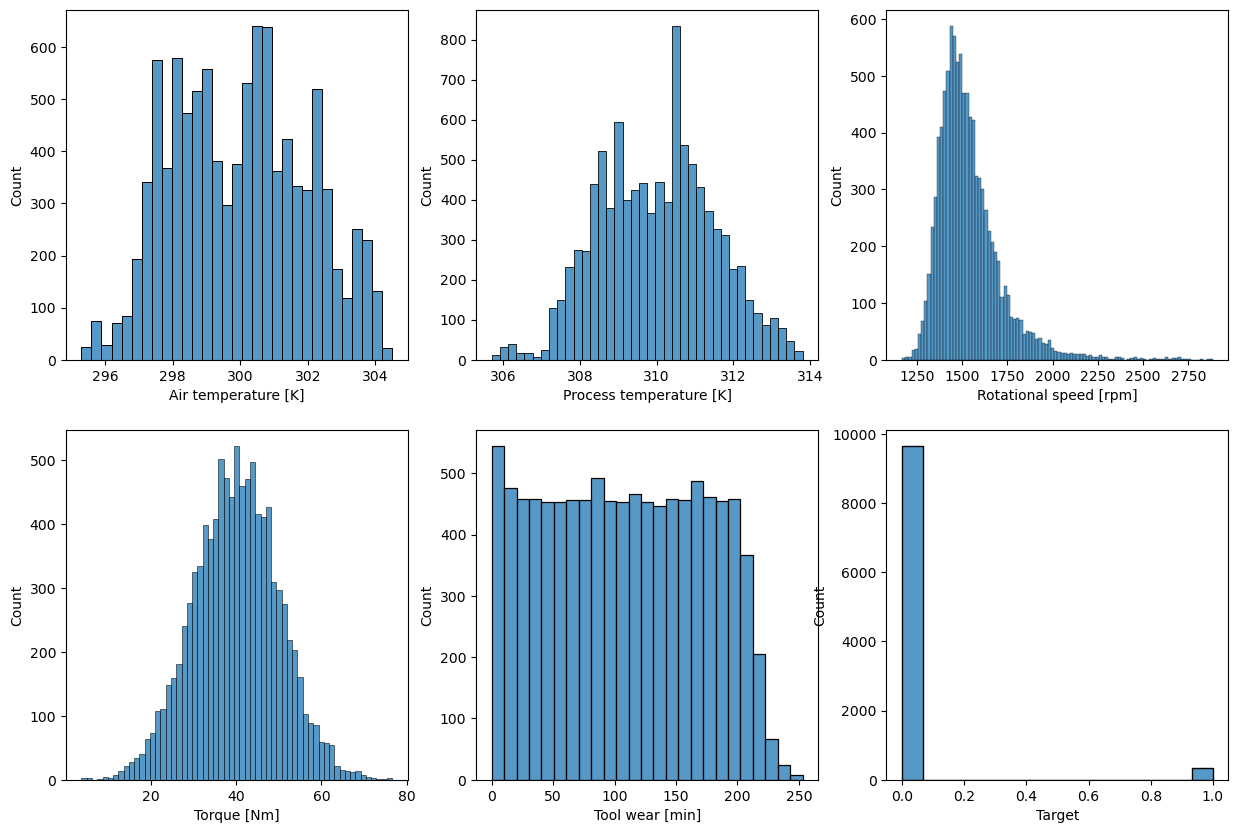

In [76]:
# Data visualization
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col)
plt.show()

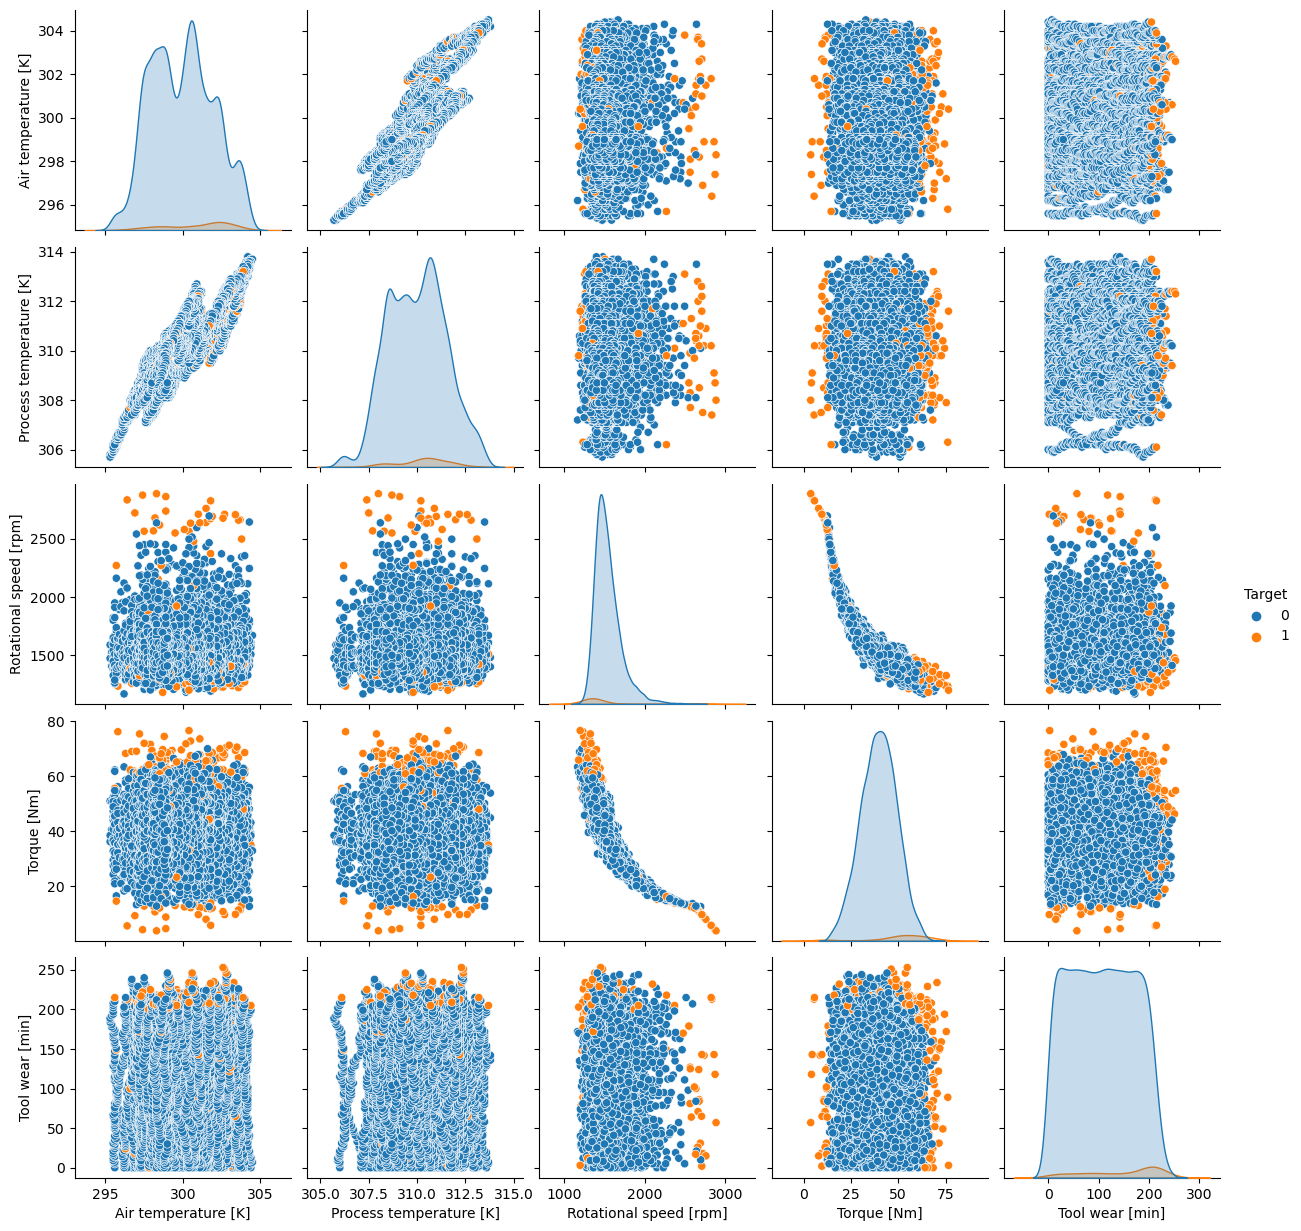

In [77]:
# Pairplot visualization
sns.pairplot(df, hue='Target')
plt.show()

In [78]:
# Preparing data for model training
x = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Target']

In [79]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [80]:
# Identify categorical and numerical columns in training data
cat_cols = X_train.select_dtypes(include='O').columns.tolist()
num_cols = X_train.select_dtypes(exclude='O').columns.tolist()

In [81]:
# Column Transformer for encoding and scaling
enc = OneHotEncoder(handle_unknown='ignore')
sc = StandardScaler()
ct = ColumnTransformer(
    [
        ('encoding', enc, cat_cols),
        ('scaling', sc, num_cols)
    ]
)

In [82]:
# Transform training and testing data
x_train = ct.fit_transform(X_train)
x_test = ct.transform(X_test)

In [83]:
# Logistic Regression model training and evaluation
clf = LogisticRegression()
clf.fit(x_train, y_train)
logistic_score = clf.score(x_test, y_test)

In [84]:
# SVM model training and evaluation
svc = SVC()
svc.fit(x_train, y_train)
svc_score = svc.score(x_test, y_test)

In [85]:
# RBF SVM model training and evaluation
rsvc = SVC(kernel='rbf')
rsvc.fit(x_train, y_train)
rsvc_score = rsvc.score(x_test, y_test)

In [86]:
# Addressing class imbalance using undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x_train, y_train)
clf.fit(X_resampled, y_resampled)
undersampling_score = clf.score(x_test, y_test)

In [87]:
# Addressing class imbalance using SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
clf.fit(X_resampled, y_resampled)
smote_score = clf.score(x_test, y_test)

In [88]:
# Using a combination of over and under-sampling
over = SMOTE(sampling_strategy=0.5)
und = RandomUnderSampler()
pipe = Pipeline(
    [
        ('o', over),
        ('u', und)
    ]
)
x_s, y_s = pipe.fit_resample(x_train, y_train)
clf.fit(x_s, y_s)
combined_score = clf.score(x_test, y_test)

In [89]:
# Outputting the scores
print("Logistic Regression Score: ", logistic_score)
print("SVC Score: ", svc_score)
print("RBF SVC Score: ", rsvc_score)
print("Logistic Regression Score after undersampling: ", undersampling_score)
print("Logistic Regression Score after SMOTE: ", smote_score)
print("Logistic Regression Score after over and under-sampling: ", combined_score)

Logistic Regression Score:  0.9744835965978129
SVC Score:  0.9778250303766707
RBF SVC Score:  0.9778250303766707
Logistic Regression Score after undersampling:  0.8277642770352369
Logistic Regression Score after SMOTE:  0.8265492102065614
Logistic Regression Score after over and under-sampling:  0.8292831105710814


In [90]:
# Ensure no infinite values are present in the dataset
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)

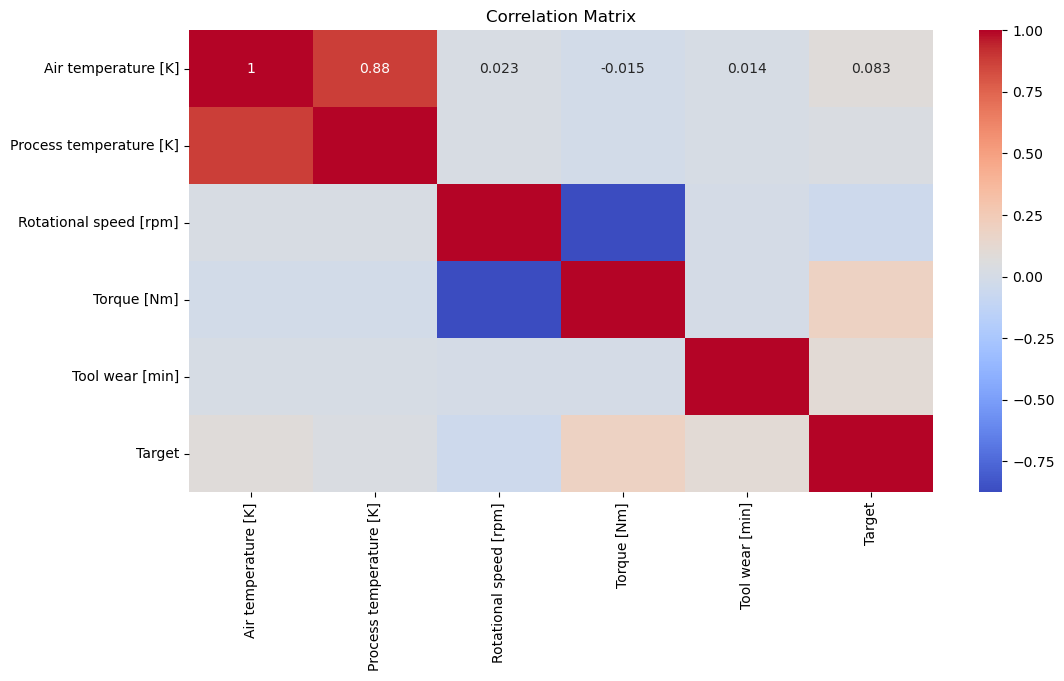

In [91]:
# Compute correlation matrix and plot heatmap excluding non-numeric column
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()